In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import BayesianOptimization

import keras



2023-12-10 17:07:26.220494: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 17:07:26.305975: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 17:07:27.042222: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 17:07:27.047490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 17:07:29.321442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# helper functions
def plot_images(images, velocity, rows, cols, title = ''):
    total_images = len(images)
    if total_images > rows * cols:
        print("Warning: More images than subplot cells. Some images may not be displayed.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < total_images:
                img = images[index]
                im = axes[i, j].imshow(img, cmap='seismic')
                axes[i, j].axis('off')
                avg_velocity = velocity[index]
                t = f"Avg velocity {avg_velocity:.2f}"
                axes[i, j].set_title(t)
                cbar = fig.colorbar(im, ax=axes[i, j], orientation='vertical', fraction=0.03, pad=0.05)

    plt.suptitle(title, fontsize=16)
    plt.show()


def downsample_images_interpolation(images, output_shape):

    num_images = images.shape[0]
    downsampled_images = np.zeros((num_images, *output_shape), dtype=images.dtype)

    for i in range(num_images):
        downsampled_images[i] = resize(images[i], output_shape, anti_aliasing=True)

    return downsampled_images

Number of training samples:  240
Number of test samples:  60
Minimum and maximum values of X_train: 0.0  -  0.33896154090792685
Minimum and maximum values of X_test: 0.0  -  0.30909245912737093
Minimum and maximum values of Y_train: 0.0  -  0.1477140937412357
Minimum and maximum values of Y_test: 0.0  -  0.13472594575015961


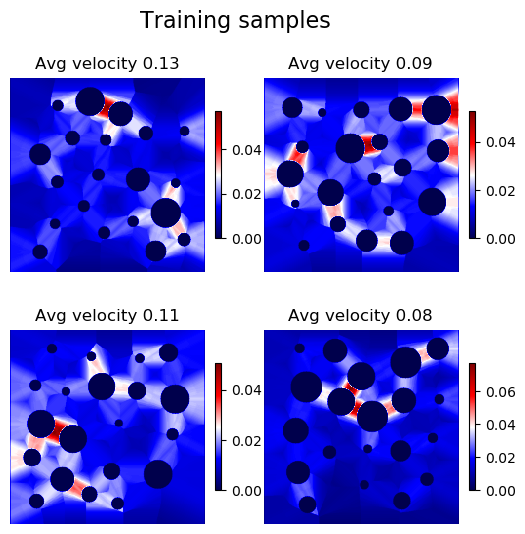

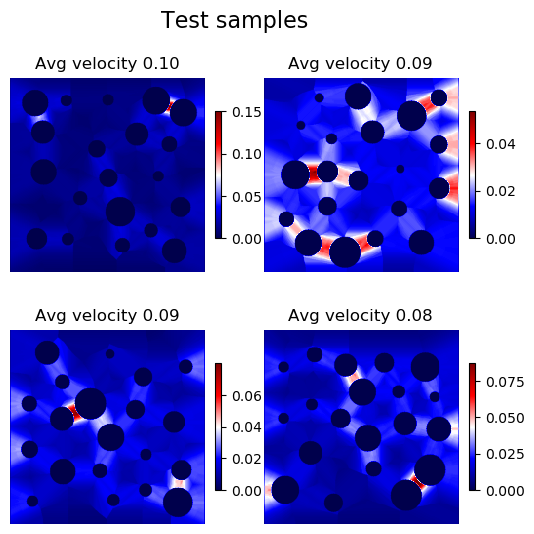

In [4]:
# Load Data
"""
# This part of the code is used only once to load data from txt files and save as npy file
# so that future loading is faster
directory = "../HPO/domain_generation"
input_images = np.zeros((300, 500, 500))
output_images = np.zeros((300, 500, 500))
for i in range(300):
    file_kn = directory + "/d" + str(i+1) + "/Kn.txt"
    file_ux = directory + "/d" + str(i+1) + "/out/UX.txt"
    kn = np.loadtxt(file_kn)
    ux = np.loadtxt(file_ux)
    kn = kn.reshape((500, 500))
    ux = ux.reshape((500, 500))
    input_images[i, :, :] = kn
    output_images[i, :, :] = ux
    print(i)

np.save('input', input_images)
np.save('output', output_images)
"""

X = np.load("../dataset/input.npy")
Y = np.load("../dataset/output.npy")
velocity = np.zeros(Y.shape[0])

# Average velocities
for i in range(Y.shape[0]):
    sample = Y[i]
    velocity[i] = np.mean(sample)

# downsample
output_shape = (200, 200)
X = downsample_images_interpolation(X, output_shape)

# split, using mean velocity as target value
X_train, X_test, Y_train, Y_test = train_test_split(X, velocity, test_size=0.2, shuffle=True, random_state=100)

print("Number of training samples: ", X_train.shape[0])
print("Number of test samples: ", X_test.shape[0])

print("Minimum and maximum values of X_train:", np.min(X_train), " - ", np.max(X_train))
print("Minimum and maximum values of X_test:", np.min(X_test), " - ", np.max(X_test))

print("Minimum and maximum values of Y_train:", np.min(X_train), " - ", np.max(Y_train))
print("Minimum and maximum values of Y_test:", np.min(X_test), " - ", np.max(Y_test))

plot_images(X_train[0:4], Y_train[0:4], rows=2, cols=2, title = 'Training samples')
plot_images(X_test[0:4], Y_test[0:4], rows=2, cols=2, title = 'Test samples')


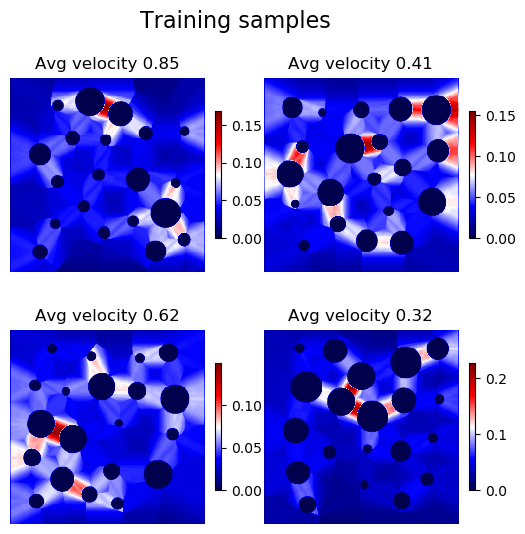

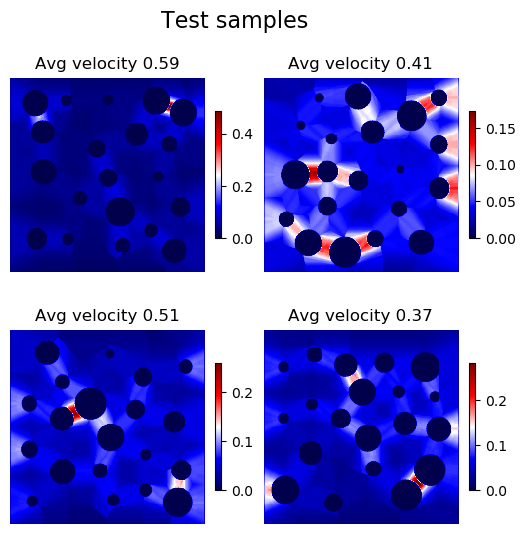

In [5]:
# preprocessing
def normalize_images(images, y=None):
    # Flatten the entire dataset
    flattened_images = images.reshape(images.shape[0], -1)

    # Normalize the entire dataset
    normalized_images = (flattened_images - flattened_images.min()) / (flattened_images.max() - flattened_images.min())

    # Reshape back to the original shape
    normalized_images = normalized_images.reshape(images.shape)

    if y is None:
        return normalized_images
    else: 
        y = (y - y.min()) / (y.max() - y.min())
        return normalized_images, y

x_train, y_train = normalize_images(X_train, Y_train)
plot_images(x_train[0:4], y_train[0:4], rows=2, cols=2, title = 'Training samples')

x_test, y_test = normalize_images(X_test, Y_test)
plot_images(x_test[0:4], y_test[0:4], rows=2, cols=2, title = 'Test samples')


In [6]:
def build_model(hp, input_shape = (200, 200, 1)):
    model = Sequential()

    # Choose the number of Conv2D and MaxPooling layers
    for i in range(hp.Int('conv_layers', min_value=1, max_value=5)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_{i}', values=[3, 5]),
            activation='relu',
            input_shape=input_shape
        ))

        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Choose the number of neurons in the Dense layer
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))

    # Choose the learning rate
    hp_learning_rate = hp.Float('lr', min_value = 1e-4, max_value=1e-2, sampling = 'linear')
    
    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_logarithmic_error',
        metrics=['mean_squared_error']
    )

    return model

In [7]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,  # Number of trials
    num_initial_points=20,  # Number of random initial points
    directory='bo_tuner',  # Specify a directory to store the tuner logs and checkpoints
    project_name='bo'
)

tuner.search_space_summary()

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=50, validation_split=0.2)

Trial 50 Complete [00h 02m 01s]
val_loss: 0.01517247874289751

Best val_loss So Far: 0.0059671117924153805
Total elapsed time: 02h 27m 44s
Best Hyperparameters:


AttributeError: 'list' object has no attribute 'values'

In [11]:
print(tuner.results_summary())
best_models = tuner.get_best_models(3)



Results summary
Results in bo_tuner/bo
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 25 summary
Hyperparameters:
conv_layers: 5
filters_0: 32
kernel_0: 5
units: 160
lr: 0.0005978506589418342
filters_1: 32
kernel_1: 5
filters_2: 64
kernel_2: 3
filters_3: 128
kernel_3: 3
filters_4: 64
kernel_4: 5
Score: 0.0059671117924153805

Trial 18 summary
Hyperparameters:
conv_layers: 3
filters_0: 96
kernel_0: 5
units: 32
lr: 0.0007570815204642272
filters_1: 32
kernel_1: 3
filters_2: 128
kernel_2: 3
filters_3: 32
kernel_3: 3
Score: 0.00835420936346054

Trial 35 summary
Hyperparameters:
conv_layers: 3
filters_0: 128
kernel_0: 3
units: 32
lr: 0.0008189047883517479
filters_1: 96
kernel_1: 5
filters_2: 32
kernel_2: 3
filters_3: 128
kernel_3: 5
filters_4: 96
kernel_4: 3
Score: 0.008448603563010693

Trial 24 summary
Hyperparameters:
conv_layers: 4
filters_0: 128
kernel_0: 5
units: 224
lr: 0.001249998188163703
filters_1: 128
kernel_1: 3
filters_2: 32
kernel_2: 3
filters_3: 96
ker

In [15]:
import math
from sklearn.model_selection import KFold

def train_model(model, x_train, y_train, epochs, batch_size, cv_folds = 5):
    n_samples = x_train.shape[0]
    epochs = math.floor(epochs / cv_folds)
    kf = KFold(n_splits=cv_folds)
    loss = []
    val_loss = []
    for iter in range(epochs):
        print(f"Iteration {iter}:")
        for i, (train_index, test_index) in enumerate(kf.split(x_train)):
            print(f"Fold {i}:")
            x = x_train[train_index]
            y = y_train[train_index]
            x_val = x_train[test_index]
            y_val = y_train[test_index]
            h = model.fit(x, y, batch_size=batch_size, epochs=1, verbose=1, validation_data = (x_val, y_val), shuffle=True)
            loss.append(h.history['loss'])
            val_loss.append(h.history['val_loss'])
    return model, loss, val_loss


In [16]:
# train all 3 models
trained_models = []

losses = []
val_losses = []
for m in range(3):
    model_ = best_models[m]
    model_, loss, val_loss = train_model(model_, x_train, y_train, epochs = 500, batch_size=1, cv_folds = 5)
    losses.append(loss)
    val_losses.append(val_loss)
    trained_models.append(model_)

Iteration 0:
Fold 0:
192/192 [==============================] - 4s 17ms/step - loss: 0.0182 - mean_squared_error: 0.0381 - val_loss: 0.0138 - val_mean_squared_error: 0.0307
Fold 1:
192/192 [==============================] - 3s 15ms/step - loss: 0.0130 - mean_squared_error: 0.0279 - val_loss: 0.0190 - val_mean_squared_error: 0.0394
Fold 2:
192/192 [==============================] - 3s 15ms/step - loss: 0.0127 - mean_squared_error: 0.0272 - val_loss: 0.0086 - val_mean_squared_error: 0.0181
Fold 3:
192/192 [==============================] - 3s 15ms/step - loss: 0.0068 - mean_squared_error: 0.0149 - val_loss: 0.0086 - val_mean_squared_error: 0.0184
Fold 4:
192/192 [==============================] - 3s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0121 - val_loss: 0.0058 - val_mean_squared_error: 0.0119
Iteration 1:
Fold 0:
192/192 [==============================] - 3s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0073 - val_loss: 0.0034 - val_mean_squared_error: 0.0080
Fold 1:
192/19

Model:  0 Error:  0.04339117657623038
Model:  1 Error:  0.036817222584277935
Model:  2 Error:  0.03819068200567077
best model:  1


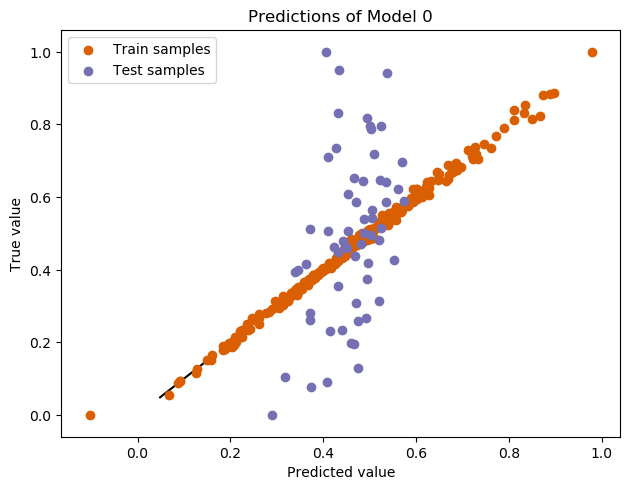

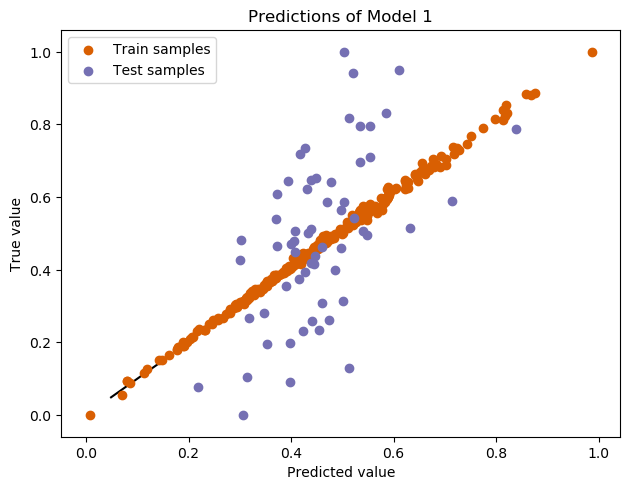

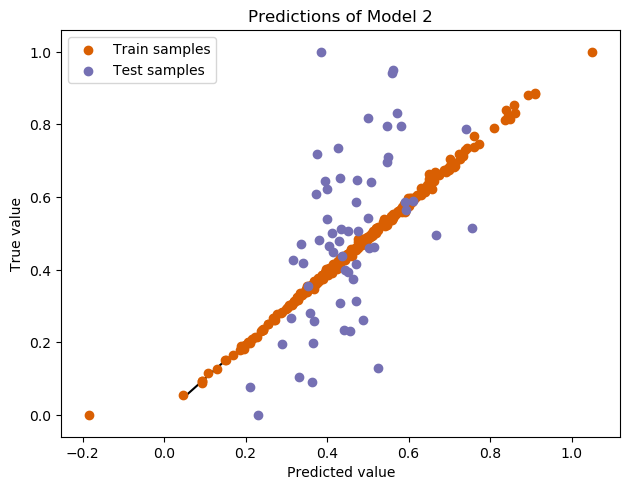

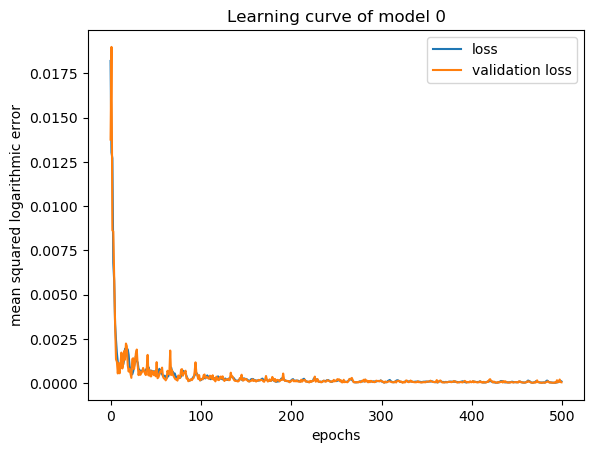

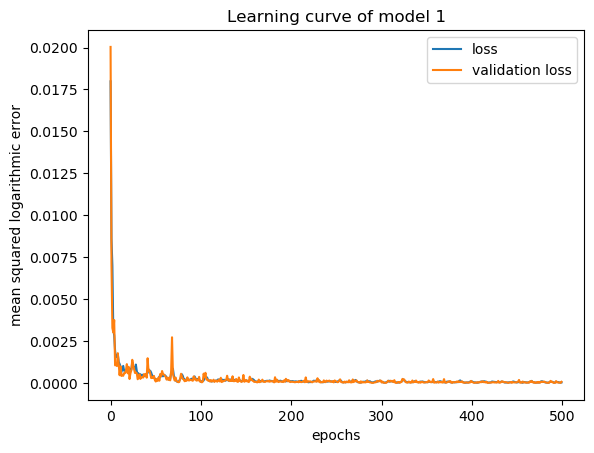

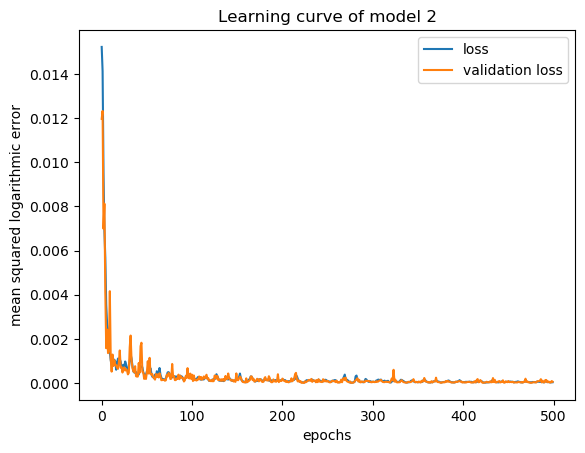

In [24]:
from sklearn.metrics import mean_squared_error
# Model Evalutaion
model_errors = []
for m in range(3):
    # calcuate test score
    err =mean_squared_error(y_test, trained_models[m].predict(x_test, verbose=0))
    model_errors.append(err)
    print("Model: ", m, "Error: ", err)


print("best model: ", model_errors.index(min(model_errors)))
best_model = trained_models[model_errors.index(min(model_errors))]

for m in range(3):
    y_train_pred = trained_models[m].predict(x_train, verbose = 0)
    y_test_pred = trained_models[m].predict(x_test, verbose = 0)

    plt.figure()
    plt.scatter(y_train_pred, y_train, label="Train samples", c="#d95f02")
    plt.scatter(y_test_pred, y_test, label="Test samples", c="#7570b3")
    plt.xlabel("Predicted value")
    plt.ylabel("True value")
    plt.legend()
    plt.plot([min(velocity), max(velocity)], [min(velocity), max(velocity)], c="k", zorder=0)
    plt.tight_layout()
    plt.title(f"Predictions of Model {m}")
    plt.show()

# plot training hsitory
for m in range(3):
    loss = losses[m]
    val_loss = val_losses[m]

    plt.figure()
    plt.plot(loss, label = 'loss')
    plt.plot(val_loss, label = 'validation loss')
    plt.xlabel('epochs')
    plt.ylabel('mean squared logarithmic error')
    plt.legend()
    plt.title(f"Learning curve of model {m}")